In [1]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import torch
from IPython.display import display
from scipy.stats import entropy
from datasets import load_dataset, Dataset, load_metric
import os.path
import os
import requests
from bs4 import BeautifulSoup

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']='1, 2'

In [3]:
training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_steps=20,
    evaluation_strategy="epoch"
    )
metric = load_metric("accuracy")

In [4]:
def compute_metrics_accuracy(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        print("Predictions", predictions, "Labels", labels)
        return metric.compute(predictions=predictions, references=labels)
        
tokenizer = AutoTokenizer.from_pretrained("oliverguhr/german-sentiment-bert")
trainer = Trainer(model= AutoModelForSequenceClassification.from_pretrained("oliverguhr/german-sentiment-bert"),
                args=training_args,
                train_dataset=None,
                eval_dataset=None,
                tokenizer=tokenizer,
                data_collator=None,
                compute_metrics = compute_metrics_accuracy)


W&B installed but not logged in. Run `wandb login` or set the WANDB_API_KEY env variable.


In [ ]:

# trainer = Trainer(model= AutoModelForSequenceClassification.from_pretrained("oliverguhr/german-sentiment-bert"),
#                 args=training_args,
#                 train_dataset=None,
#                 eval_dataset=tokenized_dataset_test,
#                 tokenizer=tokenizer,
#                 data_collator=data_collator,
#                 compute_metrics = compute_metrics_accuracy)

In [5]:
pd.set_option('display.max_rows', None)
def calculate_entropy(logits):
    probas = torch.nn.Softmax(dim=1)(torch.from_numpy(logits))
    samples_entropy = entropy(probas.transpose(0, 1).cpu())
    samples_entropy = torch.from_numpy(samples_entropy)
    return samples_entropy

def preprocess_function(examples):
    return tokenizer(examples["texts"], padding = True, truncation=True)

def get_new_sample_active_learning(number_of_comments):

    ### We read in the csv that stores all of our already annotated data
    df = pd.read_csv("annotated_data/annotated_data_with_users.csv", names=["ID", "Date", "Time", "Comment Level", "Username", "Opinion", "Sentiment",
                     "topic_comment", "Topic_article", "Comment", "Method"])

    already_present_data = 0
    with open("annotated_data/annotated_data_training.txt", encoding="utf-8", mode="r+") as y:
        for line in y.readlines():
            if line != "\n":
                already_present_data += 1

    ### Check if we already have active learned comments that we annotated
    if os.path.isfile('annotated_data/active_learning_comments.csv'):
        progress_csv =pd.read_csv("annotated_data/active_learning_comments.csv",names=["ID", "Date", "Time", "Comment Level", "Username", "Opinion", "Sentiment", "topic_comment", "Topic_article", "Comment", "Method"], encoding="utf-8-sig", header=None)


    ### Stores comments as string that we already have in active learning csv
    bereits_comments = []
    for comment in progress_csv.Comment:
        bereits_comments.append(comment)

    ### Int which shows how many comments (manual random sampled + active learn sampled) we already have annotated
    progress = already_present_data + len(bereits_comments)


    ### Load in all scraped comments from web in csv, sliced on [progress: progress + number_of_comments]
    alle_kommentare = pd.read_csv("shuffled_corona_relevante_kommentare.txt", names=["ID", "Date", "Time", "Comment Level", "Username", "Opinion", "Sentiment", "topic_comment", "Topic_article", "Comment"], 
                                    delimiter="\t", index_col=False, skiprows=progress, nrows=number_of_comments )
    


    ### Drop all rows that are already present in the active learned csv to we don't annotate twice
    alle_kommentare = alle_kommentare.loc[~alle_kommentare["Opinion"].isin(bereits_comments)]
    alle_kommentare.reset_index(inplace=True, drop=True)
    ### Tokenize texts and get entropy, take topk 
    texte = {"texts" : [x for x in alle_kommentare["Opinion"]]}
    texte_ds= Dataset.from_dict(texte)
    tokenized_text = texte_ds.map(preprocess_function, batched=True)
    entropies = calculate_entropy(trainer.predict(tokenized_text).predictions)
    indexes = torch.topk(entropies, int(30)).indices
    
    # if os.path.isfile('annotated_data/active_learning_comments.csv'):
    #     progress_csv =pd.read_csv("annotated_data/active_learning_comments.csv",names=["ID", "Date", "Time", "Comment Level", "Username", "Opinion", "Sentiment", "topic_comment", "Topic_article", "Comment"], encoding="utf-8-sig", header=None)
    #     print(type(progress_csv))
    #     display(progress_csv)
    #     for row, index in progress_csv.iterrows():
    #         print(row, index)
    newdf = pd.DataFrame(columns=["ID", "Date", "Time", "Comment Level", "Username", "Opinion", "Sentiment", "Topic_comment", "Topic_article", "Comment", "Method"])
    for nummer, x in enumerate(indexes):
        satz = texte["texts"][x]
        
        opinion = input(f"Opinion --- {satz}")
        print(type(opinion), opinion, opinion not in ["neutral", "positive", "negative", "exit"])
        while opinion not in ["neutral", "positive", "negative", "exit"]:
            
            opinion = input(f"Opinion --- {satz}")    
        sentiment = input(f"Sentiment --- {satz}")
        
        while sentiment not in ["neutral", "positive", "negative"]:
            sentiment = input(f"Sentiment --- {satz}")

        
        request = requests.get("https://www.spiegel.de/wissenschaft/medizin/corona-news-am-samstag-die-wichtigsten-entwicklungen-zu-sars-cov-2-und-covid-19-a-" +alle_kommentare.loc[int(x), "ID"])
        soup = BeautifulSoup(request.content, "html.parser")
        title = soup.find("title").text
        subtitle = soup.find("meta", property="og:description")["content"]

        topic_article = input("Topic Article ------" +title + "\n" + subtitle + " " + alle_kommentare.loc[int(x), "ID"])  
        topic_comment = input("Topic comment" + satz)


        row = [alle_kommentare.loc[alle_kommentare.Opinion == satz]]
        newdf = newdf.append(row)
        newdf.reset_index(inplace=True, drop=True)
        newdf.iloc[nummer,alle_kommentare.columns.get_loc("Topic_article")] = topic_article
        newdf.iloc[nummer,alle_kommentare.columns.get_loc("topic_comment")] = topic_comment
        newdf.iloc[nummer,alle_kommentare.columns.get_loc("Sentiment")] = sentiment
        newdf.iloc[nummer,alle_kommentare.columns.get_loc("Comment")] = satz
        newdf.iloc[nummer,alle_kommentare.columns.get_loc("Opinion")] = opinion

        print(opinion, sentiment,topic_article, topic_comment)
        

    newdf = newdf.drop(columns=list(newdf.columns[-2:]))
    display(newdf)
    newdf.to_csv("annotated_data/active_learning_comments.csv", mode="a", encoding="utf-8-sig", index=False, header=False)
            # df.append(line.split("\t")[0] + "\t" + line.split("\t")[1] + "\t" + line.split("\t")[2] + "\t" + line.split("\t")[3] + "\t" + line.split("\t")[4] + "\t" + opinion + "\t"
            #                       + sentiment + "\t" + klasse1 + "\t" +  klasse2 + "\t" + kommentar + "\n")
        



In [6]:
### Takes n/10 comments with highest entropy from n pool of comments
get_new_sample_active_learning(32500)

Opinion --- Gesundheitsschutz muss oberste Priorität haben. Jetzt sehen wir die Strategien eines Virus und müssen zeigen, dass wir gegen halten können. Wenn jetzt auch andere Altersschichten gefährdet werden, muss unser Schutzkonzept durch Testungen laufen, wir müssen die Kinder wieder in die die Schulen holen. Jeder Lehrer muss für seine Klasse die Testung durchführen. Das ist doch kein Problem. Schulobst funktioniert doch auch! positive
<class 'str'> positive False
Sentiment --- Gesundheitsschutz muss oberste Priorität haben. Jetzt sehen wir die Strategien eines Virus und müssen zeigen, dass wir gegen halten können. Wenn jetzt auch andere Altersschichten gefährdet werden, muss unser Schutzkonzept durch Testungen laufen, wir müssen die Kinder wieder in die die Schulen holen. Jeder Lehrer muss für seine Klasse die Testung durchführen. Das ist doch kein Problem. Schulobst funktioniert doch auch! neutral
Topic Article ------Corona und die Schulen: Der Testfall mit den Schnelltests - DER 

positive neutral impfung impfung
Opinion --- Ich habe Kontakte in Ländern, die hier als Entwicklungsländer gelten wie Rumänien, Bulgarien, Indien. Da ist die Digitalisierung an Schulen sicher auch nicht optimal umgesetzt, aber täglicher Online-Unterricht im Umfang eines Schultags scheint möglich zu sein. Warum bei uns nicht?  Ich vermute, dass hier beim Föderalismus bzw. noch weiter unten auf kommunaler Ebene das Problem liegt. Niemand macht von oben Vorgaben, wie das alles abzulaufen hat.negative
<class 'str'> negative False
Sentiment --- Ich habe Kontakte in Ländern, die hier als Entwicklungsländer gelten wie Rumänien, Bulgarien, Indien. Da ist die Digitalisierung an Schulen sicher auch nicht optimal umgesetzt, aber täglicher Online-Unterricht im Umfang eines Schultags scheint möglich zu sein. Warum bei uns nicht?  Ich vermute, dass hier beim Föderalismus bzw. noch weiter unten auf kommunaler Ebene das Problem liegt. Niemand macht von oben Vorgaben, wie das alles abzulaufen hat.neutr

<class 'str'> negative False
Sentiment --- Ich verstehe folgendes nicht: ich bin großer Fan des Föderalismus, ich sehe als Geschichtslehrer den Sinn. Aber wir haben momentan ein nationales Problem, für das wir Bundesländer-Lösungen suchen. Inklusive Sonderwegen, bei denen „mutige“ Landeschefs ihr sich  hoffentlich auszahlendes, risikoreiches (Öffnungen!) Vorgehen in zukünftige Wählerstimmen umzumünzen versuchen. Ich bin gerne dafür, dass das Parlament oder Merkel und die sechzehn anderen Köche etwas entscheiden und sich auf etwas einigen. Ich mag Demokratie... Aber wenn sechzehn Köche dann doch entgegen der Absprache zu den Spaghetti Bolognese dann doch ein Pesto oder doch Carbonara oder eine andere „Sondersauce“ zubereiten, kann das nichts werden....neutral
Topic Article ------Corona: Bundesregierung droht Ländern mit deutschlandweiten Regeln - DER SPIEGEL
Tun die Länder zu wenig gegen die Ausbreitung des Virus? Ein Sprecher der Bundesregierung pocht auf harte Maßnahmen – und erinnert

Sentiment --- Ständig fordert irgendjemand das Ende des Lockdowns. Dass man oder irgendwelche Berufsgruppen am 'Ende' oder 'knapp' davor sei?  Wenn interessiert es? Niemand! Wir halten jetzt durch bis September. Das Opfer ist wohl nicht zu viel verlangt!negative
Topic Article ------Corona-News: Grünen-Fraktionschefin schlägt Schulunterricht in Kirchen und Kinos vor - DER SPIEGEL
Um den Präsenzunterricht wieder zu ermöglichen, ruft Katrin Göring-Eckardt die Bundesregierung zu mehr Kreativität im Umgang mit den Schulen auf. Und: Vier Millionen Athener müssen erneut in einen harten Shutdown. Der Überblick am 9. Februar. 9c9aea47-7041-46bd-af6d-0fba7841522cüberblick
Topic commentStändig fordert irgendjemand das Ende des Lockdowns. Dass man oder irgendwelche Berufsgruppen am 'Ende' oder 'knapp' davor sei?  Wenn interessiert es? Niemand! Wir halten jetzt durch bis September. Das Opfer ist wohl nicht zu viel verlangt!lockdown
positive negative überblick lockdown
Opinion --- Da unterstellt man

<class 'str'> negative False
Sentiment --- Verwaltungsgerichte mal wieder als zuverlässige Treiber der Pandemie. Und die Begründung mal wieder jenseits von dieser Welt. In Hotels sei die Ansteckung vernachlässigbar so die Richter. Dann bitte aber auch die Touristen aus Corona-Hotspots des In- und Auslands im Hotelzimmer einschließen.      negative
Topic Article ------Corona in Schleswig-Holstein: Oberverwaltungsgericht kippt Beherbergungsverbot - DER SPIEGEL
Niederlage für die Landesregierung in Schleswig-Holstein: Das Oberverwaltungsgericht hat das Beherbergungsverbot für Touristen aus Corona-Hotspots als rechtswidrig eingestuft. 39183dc4-7424-4fab-9c1f-8e450ae4db3bmaßnahmen
Topic commentVerwaltungsgerichte mal wieder als zuverlässige Treiber der Pandemie. Und die Begründung mal wieder jenseits von dieser Welt. In Hotels sei die Ansteckung vernachlässigbar so die Richter. Dann bitte aber auch die Touristen aus Corona-Hotspots des In- und Auslands im Hotelzimmer einschließen.      maßn

,ID,Date,Time,Comment Level,Username,Opinion,Sentiment,Topic_comment,Topic_article,Comment
0,fbb7e875-60f7-4ac5-ac51-751c38670b91,2021-03-07,07:18,0,Yvonne-eXOFjKwWg,positive,neutral,tests,tests,Gesundheitsschutz muss oberste Priorität haben...
1,afe18b6e-2dbe-4052-93cc-0be9d69f8f70,2020-10-05,16:23,0,Matia-1MPFjCSGR,negative,negative,usa,demos,Das Weiße Haus hat den Fall erfolgreich behand...
2,005252b1-4577-4353-b5dd-42fb51e91866,2020-12-13,12:47,0,Cycokan,negative,negative,politik,lockdown,"Der Hamburger könnte auch mal schweigen, oder?..."
3,f20da244-be36-4491-929e-df5ce0c3f5e8,2021-04-01,13:37,0,Verena Ramona-hE5774EWg,negative,negative,politik,infektion,"Haug benennt, zwar etwas kompliziert, aber den..."
4,d15f786e-bdc3-422b-9a09-8079304724e4,2021-05-06,16:44,0,Leonard_Zelig,positive,neutral,impfung,impfung,Als 35-Jähriger hätte ich gerne die Option mic...
5,8fa3ebb6-4e05-4e27-856f-a936ebf81e56,2020-09-08,09:53,0,bruno-Li8Nk27MR,negative,neutral,politik,maßnahmen,"Ich habe Kontakte in Ländern, die hier als Ent..."
6,668a61f3-55e9-467a-93ce-bf322515597b,2020-06-17,13:14,0,Gerhard-CCCsQwPWR,neutral,neutral,sport,lockdown,Eigentlich hätte Schalke 04 Meister werden müs...
7,3d7bf693-b670-4c91-807d-7e1d99c2f044,2021-02-22,10:29,0,iuris_consultus,neutral,neutral,politik,lockerung,"In ihrer Brust schlagen mehrere Herzen, was di..."
8,ab180d76-bf2a-45f5-bcc6-375ddf52b6a5,2020-03-17,03:25,0,J.K.-INEIGAPWR,positive,positive,politik,politik,"Ich bin kein CSU Fan, aber Herr Söder macht ei..."
9,83d0e51b-1c02-4e3d-b94d-fc750248d0f8,2021-01-05,18:06,0,Sven-OFvOm_uWR,positive,neutral,maßnahmen,lockdown,"Mensch, da könnte jetzt ja so eine verrückte A..."


In [7]:
active_learning_df = pd.read_csv("annotated_data/active_learning_comments.csv", names=["ID", "Date", "Time", "Comment Level", "Username", "Opinion", "Sentiment", "Topic_comment", "Topic_article", "Comment", "Method"])
active_learning_df["Method"] = "manual_al"
active_learning_df.to_csv("annotated_data/active_learning_comments.csv",encoding="utf-8-sig", index=False, header=False)

In [9]:
active_learning_df = pd.read_csv("annotated_data/active_learning_comments.csv", names=["ID", "Date", "Time", "Comment Level", "Username", "Opinion", "Sentiment", "Topic_comment", "Topic_article", "Comment", "Method"])
current_kommentare_df = pd.read_csv("annotated_data/annotated_data_with_users_für_al.csv", names=["ID", "Date", "Time", "Comment Level", "Username", "Opinion", "Sentiment", "Topic_comment", "Topic_article", "Comment", "Method"])
full_df = current_kommentare_df.append(active_learning_df)
full_df  = full_df.sample(frac=1).reset_index(drop=True)
full_df.to_csv("annotated_data/annotated_data_with_users_and_al.csv", encoding="utf-8-sig", index=False, header=False)

<AxesSubplot:>

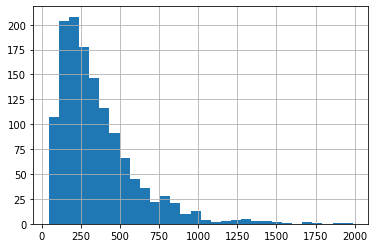

In [30]:
lengths = [len(i) for i in full_df["Comment"]]
pd.Series(lengths).hist(bins = 30)

In [10]:
import pandas as pd
df_with_XXX =pd.read_csv("annotated_data/annotated_data_with_users_and_al.csv",names=["ID", "Date", "Time", "Comment Level", "Username", "Opinion", "Sentiment", "topic_comment", "Topic_article", "Comment", "Method"], encoding="utf-8-sig", header=None)
df_test = df_with_XXX.loc[df_with_XXX["topic_comment"] != "XXX"]
df_test.to_csv("annotated_data/annotated_data_with_users_and_al_cleaned.csv", encoding="utf-8-sig", index=False, header=False)